In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import numpy as np
import os
import argparse

In [ ]:

import skimage, os
from skimage.util import montage
import matplotlib.pyplot as plt 
import sys 
import random 
import warnings
from time import time 
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Activation, add, multiply, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,CSVLogger,LearningRateScheduler
from tensorflow.keras import backend as K 
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image
from sklearn.model_selection import train_test_split
import math
from skimage.exposure import rescale_intensity
from skimage.segmentation import mark_boundaries
%matplotlib inline 
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

np.random.seed(42)
# seed = 42
# random.seed = seed 
# np.random.seed = seed

In [ ]:
# %cd /content/gdrive/My Drive/Kaggle
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle datasets download -d mishamody/compiled-0-50
# !unzip /content/gdrive/MyDrive/Kaggle/compiled-0-50.zip

In [ ]:
%cd '/content/gdrive/MyDrive/RESUNET-CROPPED/FILES'
from decay import *

/content/gdrive/MyDrive/Kaggle/RESUNET-CROPPED/FILES


In [ ]:
path = "/content/gdrive/MyDrive/Kaggle/RESUNET-CROPPED/"
os.chdir(path)

trial = 'trial29'
run=5
num_epochs = 100
loss_func = 'Tversky_Loss'
get_model='resunet'
batchsize=32
ind = True


from FILES.clr_callback import CyclicLR
from FILES.learningratefinder import LearningRateFinder
from FILES.losses import *
from FILES.model import *
from FILES.data import *

if not os.path.exists(trial):
     os.mkdir(trial)
os.chdir(os.path.join(path,trial))
print(os.getcwd())



/content/gdrive/MyDrive/Kaggle/RESUNET-CROPPED/trial29


In [ ]:
run_name = str(num_epochs)+'-'+'RUN-'+str(run) 
weight_dir = 'weights'
if not os.path.exists(weight_dir):
  os.mkdir(weight_dir)
model_checkpoint = ModelCheckpoint(os.path.join(weight_dir, run_name + '.h5'), monitor='val_loss', save_best_only=True)

log_dir = 'logs-text'
if not os.path.exists(log_dir):
  os.mkdir(log_dir)
csv_logger = CSVLogger(os.path.join(log_dir,  run_name + '.txt'), separator=',', append=True)

  #logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  #tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
def get_m(sum):
  print(f'FOLDER NAME: {run_name}')
  if get_model == 'unet':
    model=UNET()
  else:  
    model = ResUNet()
  if sum:  
    model.summary()
  return model

## **GETTING THE DATA**

Shape of x original is (7156, 128, 128, 1) and y original is (7156, 128, 128, 1)
Shape of  train is (6440, 128, 128, 1) and test is (716, 128, 128, 1)
Shape of val is (872, 128, 128, 1)
FOLDER NAME: 100-RUN-5
GETTING RESUNET
AUGMENTATION PARAM: {'horizontal_flip': True}


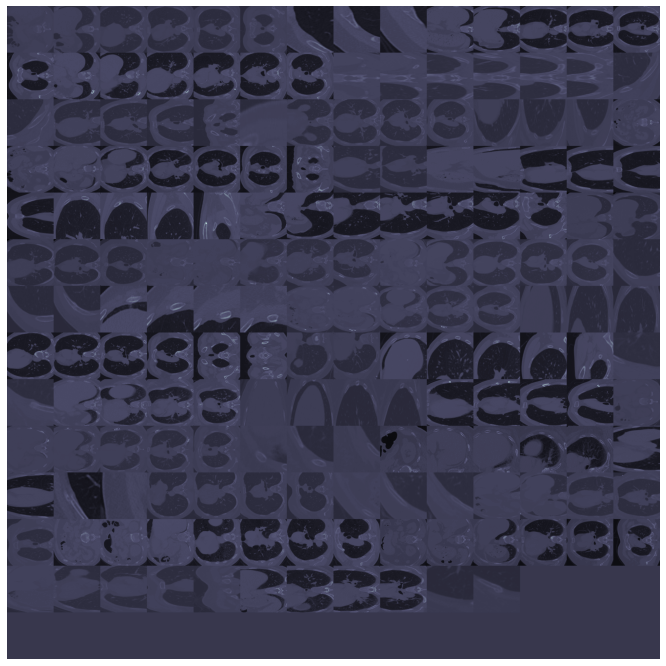

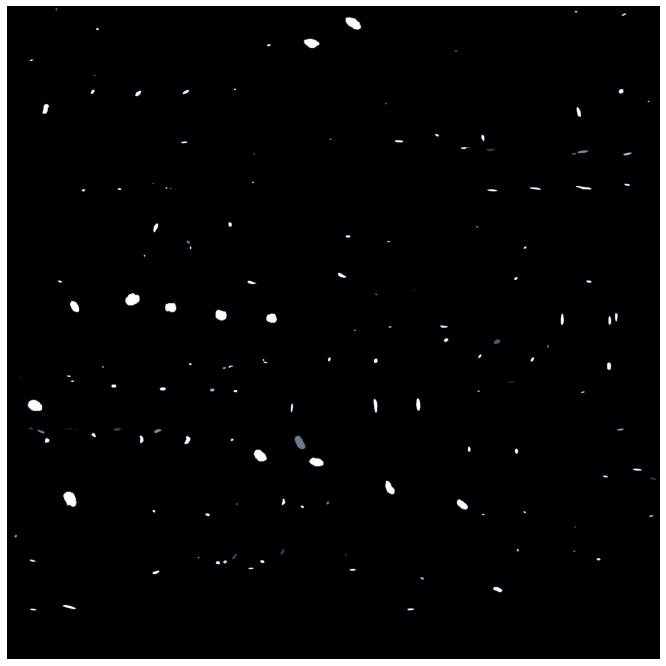

In [ ]:
x,y = get_orig_data(visualize = True)
x_train,y_train,x_test,y_test= train_test_val_split(x,y,testsplit=0.1)
x_val,y_val = get_val()
model=get_m(sum=False)
train_generator,data_gen_args=get_aug(x_train,y_train,batchsize)

In [ ]:

# lr_dir = 'lr'
# if not os.path.exists(lr_dir):
#   os.mkdir(lr_dir)
# TRAINING_PLOT_PATH = os.path.join(lr_dir,'Training'+str(run)+'.png')
# CLR_PLOT_PATH = os.path.join(lr_dir,'CLR'+str(run)+'.png')
# LRFIND_PLOT_PATH= os.path.join(lr_dir,'LRFinder'+str(run)+'.png')

# opt = keras.optimizers.SGD(lr=MIN_LR, momentum=0.9)


# model.compile(
#     optimizer=opt,
#     loss=[dice_loss],
#     metrics= [dice,IoU,'bce',DiceBCELoss,tversky,tversky_loss,log_cosh_dice_loss]
# )

# lrf = LearningRateFinder(model)
# lrf.find(
# 		train_generator,
# 		1e-10, 1e+1,
# 		stepsPerEpoch=np.ceil((len(x_train) / float(batchsize))),
# 		batchSize=batchsize)
# lrf.plot_loss()
# plt.savefig(LRFIND_PLOT_PATH)

# MIN_LR = 0.01
# MAX_LR = 1
# STEP_SIZE = 8
# CLR_METHOD = "triangular"
# clr = CyclicLR(
# 	mode=CLR_METHOD,
# 	base_lr=MIN_LR,
# 	max_lr=MAX_LR,
# 	step_size= STEP_SIZE * (len(x_train) // batchsize))




In [ ]:
s='step'
sched={
    'step': StepDecay(initAlpha=1e-1, factor=0.5, dropEvery=50),
    'linear': PolynomialDecay(maxEpochs=num_epochs, initAlpha=1e-1, power=1),
    'poly': PolynomialDecay(maxEpochs=num_epochs, initAlpha=1e-1, power=5),
    'standard':False   
}
schedule = tf.keras.callbacks.LearningRateScheduler(sched[s])

if sched['standard']:
  decay = 1e-1 / num_epochs
else:
  decay=0.0

opt = keras.optimizers.SGD(lr=1e-1, momentum=0.9, decay=decay)  

In [ ]:
model.compile(
    optimizer=opt,
    loss=[tversky_loss],
    metrics= [dice,IoU,'bce',DiceBCELoss,tversky,log_cosh_dice_loss]
)

In [ ]:
#history= model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=num_epochs,callbacks=[model_checkpoint,tensorboard_callback,csv_logger])
os.chdir(os.path.join(path,trial))
if not ind:
  if run > 1:
    model.load_weights('weights/'+'20-RUN-'+str(run-1)+ '.h5')
history= model.fit(train_generator, epochs=num_epochs,steps_per_epoch=len(x_train)//batchsize,validation_data=(x_val,y_val),callbacks=[model_checkpoint,csv_logger, schedule])

Epoch 1/100
201/201 [==============================] - 60s 124ms/step - loss: 0.7941 - dice: 0.1665 - IoU: 0.0960 - bce: 0.3823 - DiceBCELoss: 1.1505 - tversky: 0.2059 - log_cosh_dice_loss: 0.3175 - val_loss: 0.8986 - val_dice: 0.0992 - val_IoU: 0.0631 - val_bce: 2.4937 - val_DiceBCELoss: 1.4749 - val_tversky: 0.0987 - val_log_cosh_dice_loss: 0.3690
Epoch 2/100
201/201 [==============================] - 24s 118ms/step - loss: 0.5845 - dice: 0.3663 - IoU: 0.2316 - bce: 0.2463 - DiceBCELoss: 0.7655 - tversky: 0.4168 - log_cosh_dice_loss: 0.1941 - val_loss: 0.9545 - val_dice: 0.0505 - val_IoU: 0.0278 - val_bce: 1.9963 - val_DiceBCELoss: 1.4332 - val_tversky: 0.0443 - val_log_cosh_dice_loss: 0.3975
Epoch 3/100
201/201 [==============================] - 24s 117ms/step - loss: 0.5174 - dice: 0.4280 - IoU: 0.2810 - bce: 0.2300 - DiceBCELoss: 0.6824 - tversky: 0.4802 - log_cosh_dice_loss: 0.1615 - val_loss: 0.8499 - val_dice: 0.1772 - val_IoU: 0.1170 - val_bce: 0.8888 - val_DiceBCELoss: 1.1752

<Figure size 432x288 with 0 Axes>

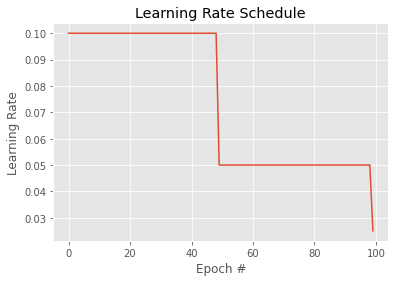

In [ ]:
lr_dir = 'lr'
if not os.path.exists(lr_dir):
  os.mkdir(lr_dir)
DECAYPATH = os.path.join(lr_dir,'decay'+str(run)+'.png')

N = np.arange(0,num_epochs)
plt.style.use("ggplot")
plt.figure()
sched[s].plot(N)
plt.savefig(DECAYPATH)
# # plot the learning rate history
# N = np.arange(0, len(clr.history["lr"]))
# plt.figure()
# plt.plot(N, clr.history["lr"])
# plt.title("Cyclical Learning Rate (CLR)")
# plt.xlabel("Training Iterations")
# plt.ylabel("Learning Rate")
# plt.savefig(CLR_PLOT_PATH)

In [ ]:
  def get_all_graphs(save):
    os.chdir(os.path.join(path,trial,'logs-text'))   
    if ind:
      files=[str(num_epochs)+'-'+'RUN-'+str(run)+'.txt']
      print(ind)
    else:  
      dirs =  os.listdir(os.path.join(path,trial,'logs-text'))
      files = [r for r in dirs if '.txt' in r]
    f = open(files[0],'r')
    first = f.readline()
    first=first.strip()
    first = first.split(',')
    dd={}
    for x in first:
      dd[x]=[]
    for file in files:
      
      g = open(file,'r')
      next(g)
      for row in g:
        row = row.split(',')
        for idx,d in enumerate(row):
          dd[first[idx]].append(float(d))


    col = 3
    fig = plt.figure(figsize=((len(files)/2+1.5) *10,(len(files)/2+1.5) *10))
    ax = []
    ep= dd.pop('epoch', None)
    epoch_array = [x for x in range(0,len(ep))]
    total = len(dd)
    rows = math.ceil(total / col)

    for idx, e in enumerate(dd):
      ax.append(fig.add_subplot(rows,col,idx+1))
      ax[-1].set_title(e)
      #plt.ylabel(e)
      #plt.xlabel('epoch')
      plt.plot(epoch_array,(np.array(dd[e])),label='train')
      name = 'val_' + e
      plt.plot(epoch_array,(np.array(dd[name])),label='val')
      print(name)
      gap = (len(files) / 2) * 10
      plt.xticks(np.arange(0, len(epoch_array) + gap, gap))
      plt.legend()
      if idx == ((total/2)-1 ):
        break
    if save:    
      plt.savefig('ALL-'+ str(run)+'.png')
    plt.show()
    return dd,files,ep


  def get_diceloss(dd,ep,save):
    fig = plt.figure(figsize=(10,7))
    epoch_array = [x for x in range(0,len(ep))]
    plt.title('DICE COEFFICEINT AND LOSS',fontweight='bold')
    plt.plot(epoch_array,(np.array(dd['dice'])),label='train')
    plt.plot(epoch_array,(np.array(dd['val_dice'])),label='val')
    plt.plot(epoch_array,(np.array(dd['loss'])),label='train')
    plt.plot(epoch_array,(np.array(dd['val_loss'])),label='val')
    plt.figtext(0.55, 0.81,"DICE COEFFICIENT", horizontalalignment ="center",  verticalalignment ="center", wrap = True, fontsize = 14, color ="green")
    plt.figtext(0.55, 0.41,"LOSS",horizontalalignment ="center",  verticalalignment ="center",  wrap = True, fontsize = 14, color ="blue")
    plt.legend()
    if save:
      plt.savefig('Dice&Loss'+str(run)+'.png')

  # os.chdir(os.path.join(path,trial))
  # print(os.getcwd())
  # %load_ext tensorboard
  # %tensorboard --logdir logs

  def get_pred(t,r,e):
    os.chdir(os.path.join(path,t))
    model.load_weights('weights/'+str(e)+'-RUN-'+r+'.h5')
    pred = model.predict(x_test, verbose=1)
    return pred

  def display_pred(savepng):
      os.chdir(os.path.join(path,trial))
      pred_path = 'pred-'+str(run)
      if not os.path.exists(pred_path):
        os.mkdir(pred_path)

      for k in range(0,len(pred),100):     
        print(k) 
        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(1,2,1)
        ax1.axes.xaxis.set_visible(False)
        ax1.axes.yaxis.set_visible(False)
        plt.title('Ground Truth')
        ax1.imshow(x_test[k][:,:,0], 'gray', interpolation='none')
        ax1.imshow(y_test[k][:,:,0], 'viridis', interpolation='none', alpha=0.7)

          #ax1.imshow((mark_boundaries(a,b)))
        ax2 = fig.add_subplot(1,2,2)
        ax2.axes.xaxis.set_visible(False)
        ax2.axes.yaxis.set_visible(False)
        plt.title('Predictions')
        ax2.imshow(x_test[k][:,:,0], 'gray', interpolation='none')
        ax2.imshow(pred[k][:,:,0], 'jet', interpolation='none', alpha=0.7)
        # if len(np.unique(y_test[k][:,:,0])) > 1:
        if savepng:
          plt.savefig(os.path.join(pred_path,'Pred-'+ str(k)+ '-of-'+ str(run) +'.png'))
        plt.show() 

  def get_IOU_DICE(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    total = np.sum(y_true_f) + np.sum(y_pred_f)
    intersection = np.sum(y_true_f * y_pred_f)
    union = total-intersection
    # smooth = .001
    smooth=1e-6
    iou = (intersection + smooth) / (union + smooth)
    dice = 2 * (intersection + smooth)/(total+ smooth)

    iou = np.mean(iou)
    dice = np.mean(dice)
    print(f'IOU : {iou}')
    print(f'Dice : {dice}')
    return (iou,dice)       

  def get_sen_spe(y_test, pred):
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    possible_positives = np.sum(np.round(np.clip(y_true, 0, 1)))
    true_negatives = np.sum(np.round(np.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = np.sum(np.round(np.clip(1 - y_true, 0, 1)))
    sen =(true_positives / (possible_positives + 1e-07))
    spe=(true_negatives / (possible_negatives + 1e-07)) 
    print(f'Sensitivity is: {sen}')
    print(f'Specificity is: {spe}')
    return sen,spe
  
  def print_eva(eva):
    i=0
    for idx,e in enumerate(eva):
      print(f'{met[i]} : {e}')
      i=i+1



True
val_DiceBCELoss
val_IoU
val_bce
val_dice
val_log_cosh_dice_loss
val_loss
val_tversky


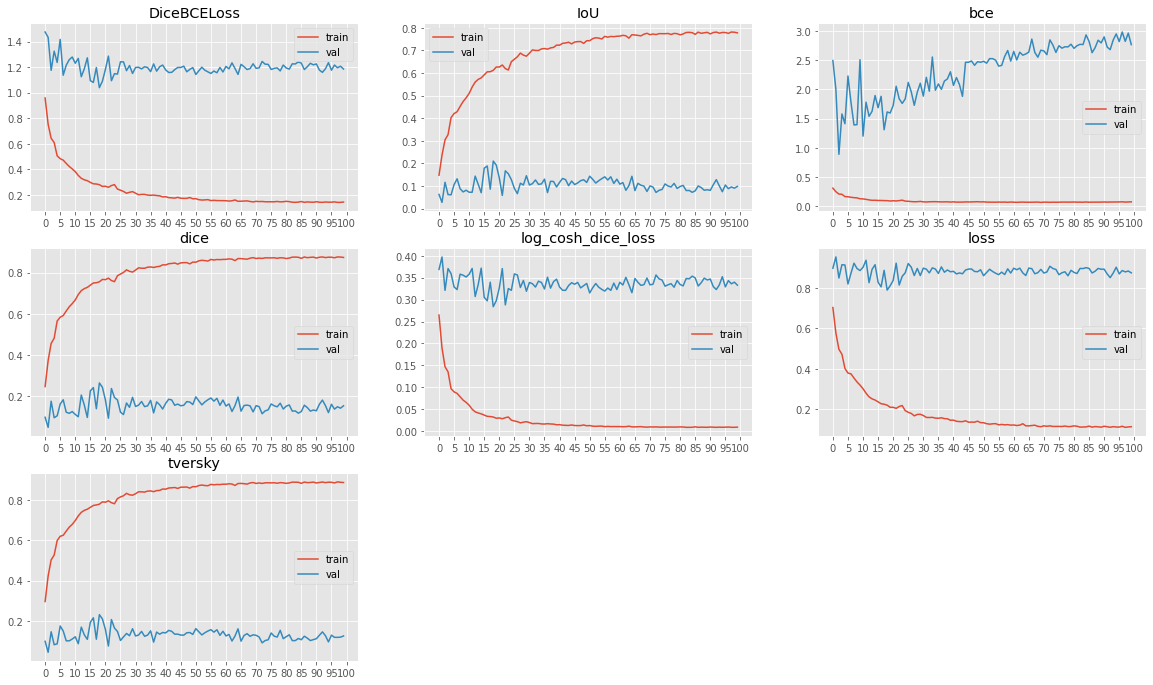

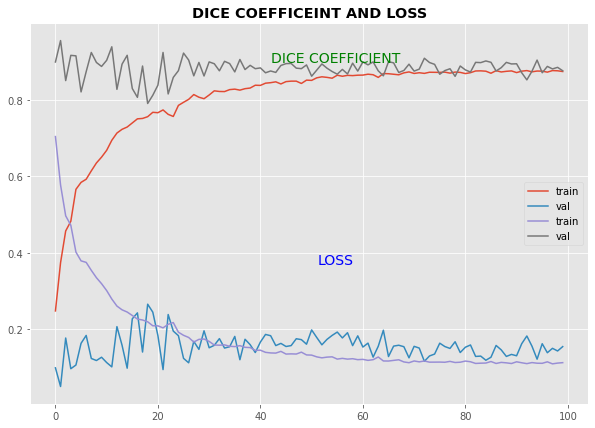

In [ ]:
dd,files,ep=get_all_graphs(save=True)
get_diceloss(dd,ep,save=True)

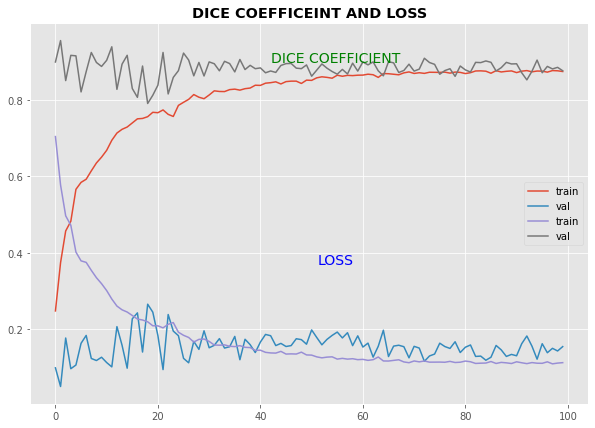

In [ ]:
get_diceloss(dd,ep,save=True)

**MAKE PREDICTIONS**

23/23 [==============================] - 1s 43ms/step
0


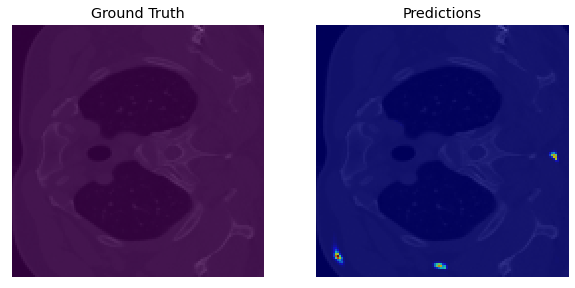

100


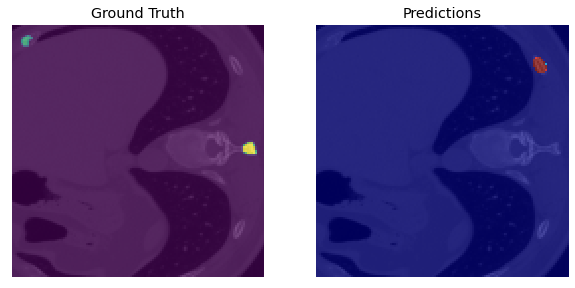

200


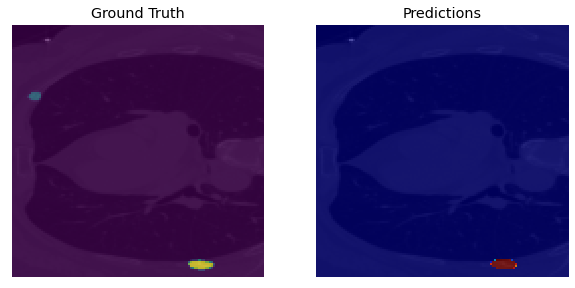

300


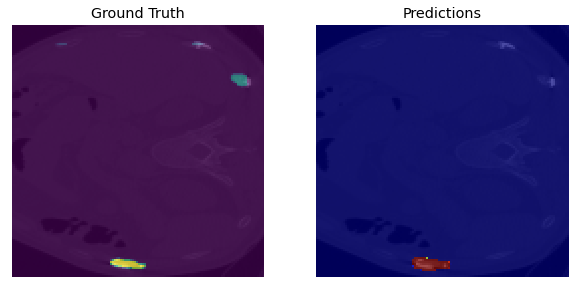

400


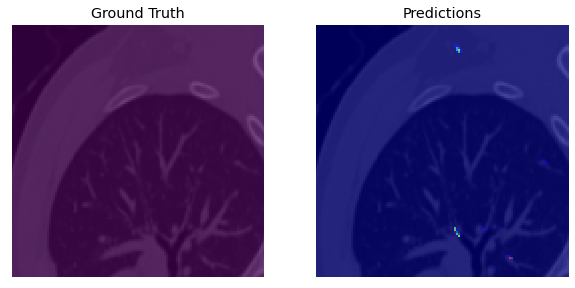

500


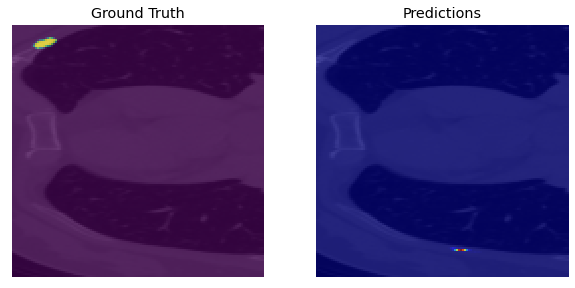

600


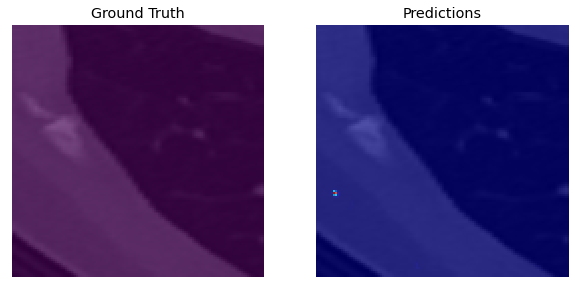

700


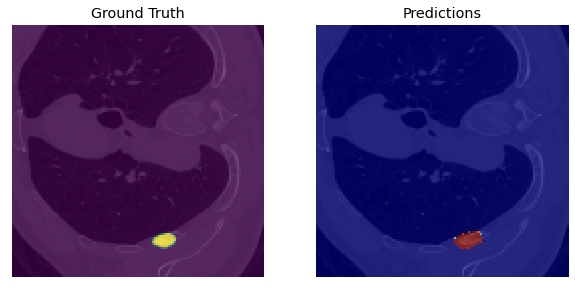

In [ ]:
#pred = get_pred(t = 'trial22' , r = '3', e = (num_epochs))
pred = get_pred(t = trial , r = str(run), e = str(num_epochs))
display_pred(savepng=False)
y_pred= pred
y_true = y_test

In [ ]:
def get_roc_auc(save):  
  nbr_of_thresholds = 40
  proba_map = y_pred.astype(np.float32)
  ground_truth = y_true.astype(np.float32) 
  threshold_list = (np.linspace(np.min(proba_map),np.max(proba_map),nbr_of_thresholds)).tolist()
  sensitivity_list_treshold = []
  FPavg_list_treshold = []
  TP = []
  FP = []
  FN = []
  TN = [] 
  for threshold in (np.linspace(np.min(y_pred),np.max(y_pred),40)):
        temp_TP=0.0
        temp_FP=0.0
        temp_FN=0.0
        temp_TN=0.0
        

        for index in range(len(y_true)):
          gt_img=y_true[index]
          prob_img=y_pred[index]

          gt_img=(gt_img>0)*1
          prob_img=(prob_img>=threshold)*1

          temp_TP = temp_TP + (np.sum(prob_img * gt_img))
          temp_FP = temp_FP + np.sum(prob_img * ((1 - gt_img)))
          temp_FN = temp_FN + np.sum(((1 - prob_img)) * ((gt_img)))
          temp_TN = temp_TN + np.sum(((1 - prob_img)) * (1 - gt_img))

        TP.append(temp_TP)
        FP.append(temp_FP)
        FN.append(temp_FN)
        TN.append(temp_TN)

  TP = np.asarray(TP).astype('float32')
  FP = np.asarray(FP).astype('float32')
  FN = np.asarray(FN).astype('float32')
  TN = np.asarray(TN).astype('float32')

  FPR = (FP) / (FP + TN)
  TPR = (TP) / (TP + FN)
  AUC = np.round(np.sum((TPR[1:] + TPR[:-1]) * (FPR[:-1] - FPR[1:])) / 2., 4)

  Precision = (TP) / (TP + FP)
  Recall = TP / (TP + FN)
  MAP = np.round(np.sum((Precision[1:] + Precision[:-1]) * (Recall[:-1] - Recall[1:])) / 2.,4)

  print(f'AUC: '+str(AUC))
  print(f'MAP: '+str(MAP))

  plt.figure(1)
  plt.title('ROC Curve', fontsize=15)
  plt.xlabel("False Positive Rate", fontsize=15)
  plt.ylabel("True Positive Rate", fontsize=15)
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  for i in range(0,1):
    plt.plot(FPR, TPR, color='red', linewidth=2.0, label='AUC:'+str(AUC))
  plt.legend()
  if save:
   plt.savefig(os.path.join('logs-text','ROC'+str(run)+'.png'))
  plt.show()

  plt.figure(2)
  plt.title('PR Curve', fontsize=15)
  plt.xlabel("Recall", fontsize=15)
  plt.ylabel("Precision", fontsize=15)
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  for i in range(0,1):
    plt.plot(FPR, TPR, color='red', linewidth=2.0,label='MAP:'+str(MAP))
  plt.legend()
  if save:
   plt.savefig(os.path.join('logs-text','PR'+str(run)+'.png'))
  plt.show()  

IOU : 0.610787760462017
Dice : 0.7583714943189477
Sensitivity is: 0.8398191676291437
Specificity is: 0.9979745975452444
23/23 [==============================] - 1s 32ms/step - loss: 0.9441 - dice: 0.0748 - IoU: 0.0399 - bce: 0.5309 - DiceBCELoss: 1.0323 - tversky: 0.0559 - log_cosh_dice_loss: 0.3790
loss : 0.9440711736679077
dice : 0.07477069646120071
IoU : 0.039909254759550095
bce : 0.5308834314346313
DiceBCELoss : 1.0322751998901367
tversky : 0.05590764433145523
tversky_loss : 0.3789518475532532
AUC: 0.8167
MAP: 0.2424


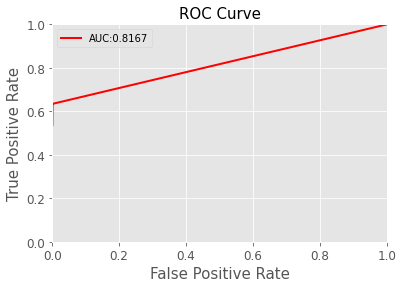

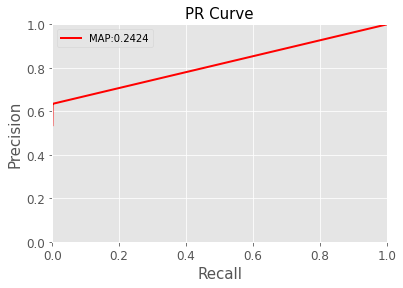

In [ ]:
i,d = get_IOU_DICE(y_true,y_pred)
sen,spe =get_sen_spe(y_true, pred)
met = ['loss','dice','IoU','bce','DiceBCELoss','tversky','tversky_loss','log_cosh_dice_loss']
eva = model.evaluate(y_true,pred)
print_eva(eva)
get_roc_auc(save=False)

In [ ]:
def make_info(dice,iou):
  os.chdir(os.path.join(path,trial))
  li=1
  L0 = ["\n\n"+str(li)+".  "+"TRIAL - " + str(trial) + " and RUN- " + str(run)+"  Independant "+str(ind),"\n\n2.  Batch size - "+ str(batchsize)+"  , Num of epoch - "+ str(len(ep)) +"  , Loss - "+ loss_func+ '  , Model - '+get_model] 
  li=li+2
  L1=["\n"+str(li)+'.  '+s+' decay learning rate with ILR = O.1 , DROP = 0.5 and ED= 50. Half after 50 epochs']
  li=li+1
  L2 = ["\n\n"+str(li)+".  "+"x len - " + str(len(x)) + " , y len - " + str(len(y))]
  li=li+1
  L3 = ["\n"+str(li)+".  "+"x_train len - " + str(len(x_train)) + " , y_train len - " + str(len(y_train)) + "  , x_test len - " + str(len(x_test)) + " , y_test len - " + str(len(y_test))]
  li=li+1
  L4 = ["\n"+str(li)+".  "+ "x_val len - " + str(len(x_val)) + " , y_val len - " + str(len(y_val))]
  li=li+2
  L5 = ['\n\n'+str(li)+".  "+"Data Augmentation : " + str(data_gen_args)]
  li=li+2
  L6 = ["\n\n"+str(li)+".  "+"Evaluation","\n\n10.  Dice - "+ str(dice) + "  , IOU - "+str(iou)]
  li=li+3
  L7 = ["\n"+str(li)+".  "+"Sensitivity - " + str(sen) + " , Specificity - " + str(spe) ]
  
  L =L0+L1+L2+L3+L4+L5+L6+L7  

  d1 = open('Info.txt','a')
  d1.writelines(l for l in L)

  i=0
  li=li+1
  d1.write("\n"+str(li)+".  ")
  for idx,e in enumerate(eva):
    li=li+1
    d1.write("\n"+str(li)+".  "+met[i]+" : "+str(e))
    i=i+1

  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(y_true, y_pred)
  li=li+2
  d1.write("\n\n"+str(li)+".  "+'Mean IoU : '+str(m.result().numpy()))

  li=li+2
  d1.write("\n\n"+str(li)+".  "+'TOTAL EPOCHS : '+ str(len(files)*100)+'\n\n\n')
  li=li+3  

  d1.close()




In [ ]:
make_info(d,i)

In [ ]:
# x_train_with_mask=[]
# y_train_with_mask=[]
# x_train_without_mask=[]
# y_train_without_mask=[]
# cnt=0
# for x in range(0,len(y_train)):
#   if len(np.unique(y_train[x])) == 1:
#     x_train_without_mask.append(x_train[x])
#     y_train_without_mask.append(y_train[x])
#   else:
#     x_train_with_mask.append(x_train[x])
#     y_train_with_mask.append(y_train[x])
    
# print(len(x_train_with_mask),len(x_train_without_mask))


# def shuffle_in_unison(a, b):
#     rng_state = np.random.get_state()
#     np.random.shuffle(a)
#     np.random.set_state(rng_state)
#     np.random.shuffle(b)


# x_train = np.array(x_train_list)
# y_train = np.array(y_train_list)
# x_val = np.array(x_val_list)
# y_val= np.array(y_val_list)
# shuffle_in_unison(x_train,y_train)
# shuffle_in_unison(x_val,y_val)
# ps(x_train)
# ps(y_train)
# ps(x_val)
# ps(y_val)

In [ ]:
# last_n_lines_to_delete = 9
# first_n_lines_to_delete=2
#nth_line = 0

# a_file = open("Info.txt", "r")
# lines = a_file.readlines()
# a_file.close()

# for idx,line in enumerate(lines):
#   print(f'index {idx} : {line}')

# lines[2] = "1.  TRIAL - trial24 and RUN- 1\n"
# del lines[-last_n_lines_to_delete:]
# del lines[:first_n_lines_to_delete]
# del lines[nth_line-1]

# new_file = open("Info.txt", "w+")
# for line in lines:
#    new_file.write(line)

# new_file.close()

In [ ]:
# import os
# os.remove('/weights/'+epoch +'-RUN-'+str(run)+".txt")
# os.remove('/logs-text/'+epoch +'-RUN-'+str(run)+".h5")

In [ ]:

# delete_line = "x len - 7156 , y len - 7156"
# reps=[] 
# a_file = open("Info.txt", "r")
# lines = a_file.readlines()
# a_file.close()

# for idx,line in enumerate(lines):    
#     if line.strip("\n") == delete_line :
#        reps.append(idx)
# print(reps)       

In [ ]:
# del lines[reps[1]]

# new_file = open("Info.txt", "w+")
# for line in lines:
#    new_file.write(line)

# new_file.close()